## Examples for HiCPAP

This notebook is separated in two parts:

1. Plotting with the Hi-C Pearson matrix & Approximated PC1-pattern.
2. (Bonus) How to reproduce the experiments in our paper.

In the 1st part we explain how to create the Approximated pc1-pattern from Hi-C Pearson correlation matrix, which is the main usage of HiCPAP. We use the dataset provided by [Aiden Lab](https://aidenlab.org/data.html) (GM12878, chromosome 1, resolution 1000000) to illustrate how to plot the Hi-C Pearson matrix with Approximated PC1-pattern for the A/B compartment analysis.

In the 2nd part we explain how to create the figures for comparing the difference between PC1 and the Approximated PC1-pattern in our paper. You can skip this part if you're only interested in how to create the Approximated PC1-pattern. 

**Please note that:**

1. HiCPAP returns the Pearson matrix, PC1 and Approximated PC1-pattern in the `numpy.ndarray` format.
2. The input Pearson matrix should be `D*D` and symmetric (D: the length of the x/y axis). 
3. All the `NaN` value should be replace with `0` in advance.
4. HiCPAP will only extract the valid non-zero sub-matrix, which is originally not `NaN`, for the calculation. However HiCPAP will keep the shape of the origin matrix, since the origin `NaN` entries still provide the important information.

For example:

(1) HiC Pearson matrix (4*4, symmetric).
```py
[
    [1,   NaN, NaN, 0.2],
    [NaN, NaN, NaN, NaN],
    [NaN, NaN, NaN, NaN],
    [0.2, NaN, NaN,   1],
]
```
(2) Fill NaN with 0.
```py
[
    [1,   0.0, 0.0, 0.2],
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0],
    [0.2, 0.0, 0.0,   1],
]
```
(3) Only the non-zero sub-matrix will be calculated. For example, calculated the covariance of the sub-matrix with `np.cov()`.
```py
[
    [1,   0.2],
    [0.2,   1],
]
```
(4) After the calculation, the shape of the origin matrix will still be kept.
```py
[
    [ 0.32, 0.0, 0.0, -0.32],
    [ 0.0,  0.0, 0.0,   0.0],
    [ 0.0,  0.0, 0.0,   0.0],
    [-0.32, 0.0, 0.0,  0.32],
]
```

In [12]:
%%bash
# The approximated PC1-pattern and figures will be stored in the created `output` directory.
mkdir -p "./outputs"

In [13]:
import numpy as np
import pandas as pd
from hicpap import paptools

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=50)

### 1. Plotting with the Hi-C Pearson matrix & Approximated PC1-pattern.

#### Step 1. Create the Hi-C Pearson matrix.

First of all, we assume the experiments are based on the [Juicer's Hi-C ecosystem](https://github.com/aidenlab/juicer). However if you already have your own Hi-C Pearson matrix in the `numpy.ndarray` format, you can still use HiCPAP for creating the Approximated PC1-patterns. 

We suppose there are three use cases for people who would like to try HiCPAP in there experiments (All these cases will return Pearson matrix in the `numpy.ndarray` format, and the `NaN` values will be replaced with `0`): 

(1) You have created the Pearson matrix `.txt` file with [juicer_tools](https://github.com/aidenlab/juicer/wiki/Pearsons). We provide a function to read in and pre-process the Pearson text file. 

```py
pearson_np = paptools.read_pearson(
    pearson="./data/juicer_data/gm12878_1000000_pearson_chr1.txt", # Path to the `.txt` file.
    format="juicer"
)
```

(2) You have prepared your own `.hic` (Juicer ecosystem), or you decide to use the Hi-C files through [the URL](https://aidenlab.org/data.html). We utilize the [straw](https://github.com/aidenlab/straw) API for creating the intra-chromosomal Pearson matrix. 

```py
pearson_np = paptools.straw_to_pearson(
    hic_path="https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic", # Path to the Juicer's `.hic` file.
    chrom_x="1", 
    chrom_y="1",
    resolution=1000000,
    normalization="KR",
    data_type="oe", # Note that the Pearson matrix should be derived from the O/E matrix.
)
```

(3) You already have your own Hi-C Pearson matrix in the `numpy.ndarray` format. For example, a `3*3` Pearson matrix with all `NaN` in the second row/column. 
```py
pearson_np = np.array([
    [1, np.nan, 0.2],
    [np.nan, np.nan, np.nan],
    [0.2, np.nan, 1]
])
pearson_np = np.nan_to_num(pearson_np, nan=0.0)
```


In [14]:
# Case 1, read in the juicer_tools created Pearson text file. 
pearson_np = paptools.read_pearson(
    pearson="./data/juicer_data/gm12878_1000000_pearson_chr1.txt",
    format="juicer"
)

print(f"Pearson_np:\n {pearson_np}\n")

Pearson_np:
 [[ 1.      0.146  -0.0449 ... -0.0375  0.4059  0.8426]
 [ 0.146   1.      0.4182 ... -0.4695 -0.582  -0.3026]
 [-0.0449  0.4182  1.     ... -0.5289 -0.4666 -0.3355]
 ...
 [-0.0375 -0.4695 -0.5289 ...  1.      0.8141  0.4091]
 [ 0.4059 -0.582  -0.4666 ...  0.8141  1.      0.7728]
 [ 0.8426 -0.3026 -0.3355 ...  0.4091  0.7728  1.    ]]



#### Step 2. Create the Approximated PC1-pattern.

The `paptools.create_approx()` function will accept the Pearson matrix created in step 1. and return the Approximated PC1-pattern in `numpy.ndarray`. 

If the output file path is specified, it will also write the Approximated PC1-pattern to the text file. 

In [15]:
output = "./outputs/gm12878_1000000_approx_pc1_chr1.txt" # output file path.
approx_np = paptools.create_approx(pearson_np=pearson_np, output=output)
print(f"approx_np: {approx_np}")

approx_np: [ 0.1182 -0.3513 -0.2252 ...  0.2936  0.3887  0.2949]


#### Step 3. Flip the Approximated PC1-pattern according to the GC-content.

In the A/B compartment analysis we usually flip the PC1 according to the average GC content of regions with positive and those with negative eigenvector entries, in order to orient the positive entries to 'A' compartment (high GC content) and negative entries to 'B' compartment (low GC content). The same idea can also be applied to the Approximated PC1-pattern, since it plays the identical role as the PC1 in compartment analysis. (For more details please read [FAN-C: Framework for the ANalysis of C-like data](https://fan-c.readthedocs.io/en/latest/fanc-executable/fanc-analyse-hic/ab_compartments.html#ab-eigenvector)).

Note that we didn't implement the flip-track function in HiCPAP, since it highly depends on which reference genome is used for mapping the `.hic` file. Here we shows how to flip the Approximated PC1-pattern if the `.hic` used the hg19 as the reference genome, besides we have already created files containing the GC-content information for hg18 (Used in [Lieberman, 2009](https://aidenlab.org/papers/Science.Genome.Folding.pdf)), hg19 and mm9 (Both used in [Rao, 2014](https://doi.org/10.1016/j.cell.2014.11.021)) at the resolution of 1Mb and 100Kb, stored in the [reference_gc](./data/reference_gc/) directory.  

If you are interested in how we created these GC content information files, please check the [create_ref_gc.sh](https://github.com/ZhiRongDev/HiCPAP/code_for_paper/create_ref_gc.sh). You can also create the GC-content information files through the function `bioframe.frac_gc` provided by [Open2C cooltools](https://cooltools.readthedocs.io/en/latest/notebooks/compartments_and_saddles.html#Calculating-per-chromosome-compartmentalization). 

In [16]:
# Flip track according to the GC content.
def flip_track_gc(track_np: np.ndarray, gc_np: np.ndarray) -> np.ndarray:
    if np.mean(gc_np[track_np > 0]) < np.mean(gc_np[track_np < 0]):
        track_np = -track_np
    return track_np

gc_df = pd.read_table("./data/reference_gc/hg19/hg19_gc1000000_chr1.txt", skiprows=[0], names=["bin", "GC"])
gc_np = gc_df["GC"].values.flatten()


"""
Note that the GC content information files created by the UCSC Genome Browser tool missed the last bin of each chromosome, 
here we removed the last bin of the approx_np to make the length of approx_np same as the length of gc_np.
"""
approx_np = approx_np[:-1]
approx_np = flip_track_gc(track_np=approx_np, gc_np=gc_np)
print(f"Flipped approx_np: {approx_np}")

Flipped approx_np: [-0.1182  0.3513  0.2252 ...  0.0107 -0.2936 -0.3887]


#### Step 4. Plot the Approximated PC1-pattern with the Pearson matrix.

This is actually the last step. Now we have both the Hi-C Pearson matrix and Approximated PC1-pattern, here we show how to plot them together for identifying the A/B compartments. The blue-color regions in the Approximated PC1-pattern bar plot on top of the Pearson matrix are identified as A compartment (positive sign), and the red-color regions are identified as B compartments (negative sign).

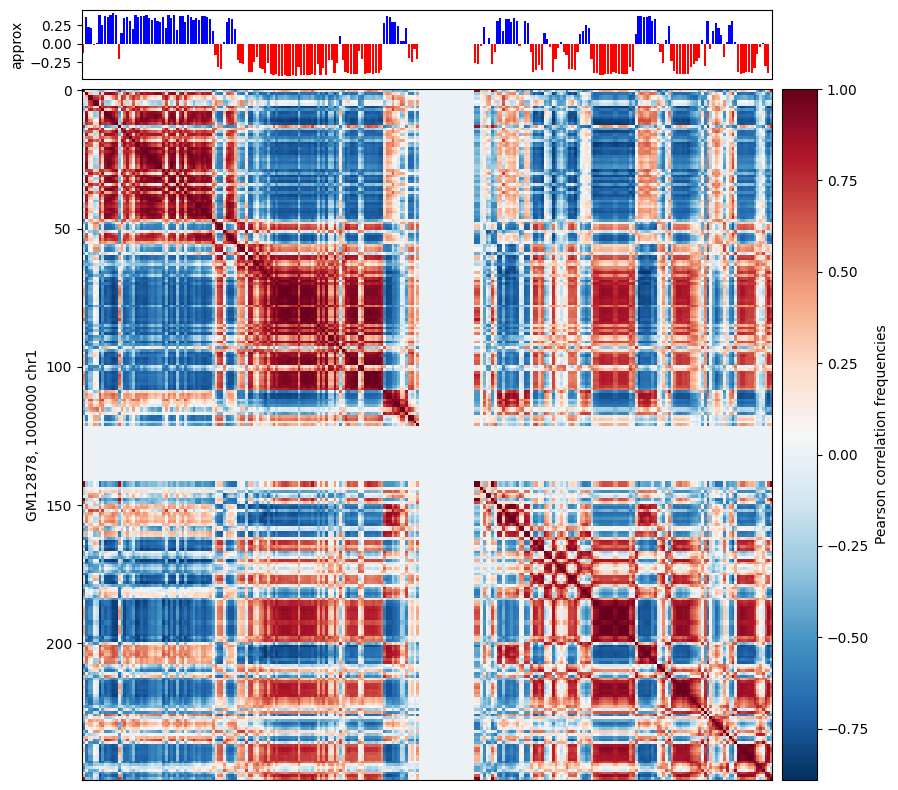

In [17]:
cell_line = "GM12878"
resolution = 1000000
chrom = "1"

f, ax = plt.subplots(
    figsize=(15, 10),
)

im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='Pearson correlation frequencies')
ax.set_ylabel(f'{cell_line}, {resolution} chr{chrom}')
ax.xaxis.set_visible(False)

ax = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
approx_x_axis = [i for i in range(0, len(approx_np))]
approx_bar_color = ['b' if i > 0 else 'r' for i in approx_np]
ax.bar(x=approx_x_axis, height=approx_np, color=approx_bar_color)
ax.set_ylabel('approx')
ax.xaxis.set_visible(False)

#### Summary (1st part)

Here we summarize the main usage of HiCPAP:

1. Get the Pearson matrix through the `paptools.read_pearson()` or `paptools.straw_to_pearson()`.
2. Create the Approximated PC1-pattern with `paptools.create_approx()`.

In [18]:
del f, im, ax

### 2. (Bonus) How to reproduce the experiments in our paper. 

In addition to the functions mentioned in the 1st part, HiCPAP also provide some APIs for the traditional PC1-based A/B compartment analysis and the comparison between the PC1 & Approximated PC1-pattern.  

1. API for performing PCA on the Pearson matrix.  

In [19]:
Vh, explained_variances, total_entry_num, valid_entry_num = paptools.pca_on_pearson(pearson_np=pearson_np)
pc1_np = Vh[0]
pc2_np = Vh[1]
pc3_np = Vh[2]

print(f"PC1: {pc1_np}")
print(f"PC2: {pc2_np}")
print(f"PC3: {pc3_np}")
print(f"Explained variance for PC1: {explained_variances[0]}")
print(f"Explained variance for PC2: {explained_variances[1]}")
print(f"Explained variance for PC3: {explained_variances[2]}")
print(f"total_entry_num (Include the origin NaN entries): {total_entry_num}")
print(f"valid_entry_num (Exclude the origin NaN entries): {valid_entry_num}")

PC1: [-0.0241  0.0759  0.0487 ... -0.0633 -0.083  -0.0624]
PC2: [-0.0536 -0.0055 -0.1206 ...  0.0592 -0.0076 -0.0192]
PC3: [ 0.1081  0.0879 -0.0366 ...  0.039   0.0504  0.0846]
Explained variance for PC1: 0.8449300048084089
Explained variance for PC2: 0.0698847762176362
Explained variance for PC3: 0.04036513148910297
total_entry_num (Include the origin NaN entries): 250
valid_entry_num (Exclude the origin NaN entries): 230


2. Compare the similarity between PC1 and the Approximated PC1-pattern.

In [20]:
# Compare the similarity between the HiCPAP calculated PC1 and the Approximated PC1-pattern.
pc1_np = pc1_np[:-1]
pc1_np = flip_track_gc(track_np=pc1_np, gc_np=gc_np)
similarity_info = paptools.calc_similarity(pc1_np=pc1_np, approx_np=approx_np)
print(f"1. {similarity_info}")


# Compare the similarity between the Juicer calculated PC1 and the Approximated PC1-pattern.
juicer_pc1 = "./data/juicer_data/gm12878_1000000_pc1_chr1.txt"
juicer_pc1_df = pd.read_table(juicer_pc1, header=None)
juicer_pc1_np = juicer_pc1_df.fillna(0).values.flatten()

juicer_pc1_np = juicer_pc1_np[:-1]
juicer_pc1_np = flip_track_gc(track_np=juicer_pc1_np, gc_np=gc_np)
similarity_info = paptools.calc_similarity(pc1_np=juicer_pc1_np, approx_np=approx_np)
print(f"2. {similarity_info}")

1. {'total_entry_num': 249, 'valid_entry_num': 229, 'similar_num': 227, 'similar_rate': 0.9912663755458515}
2. {'total_entry_num': 249, 'valid_entry_num': 229, 'similar_num': 224, 'similar_rate': 0.9781659388646288}


3. Save both the scatter and the relative_magnitude plots to the [outputs](./outputs/) directory.

In [21]:
paptools.plot_comparison(
    pc1_np=pc1_np,
    approx_np=approx_np,
    figsize=20,
    scatter="./outputs/gm12878_1000000_chr1_scatter.png",
    relative_magnitude="./outputs/gm12878_1000000_chr1_relative_magnitude.png"
)

Output:

> scatter
![scatter](outputs/gm12878_1000000_chr1_scatter.png)

> relative_magnitude
![relative_magnitude](outputs/gm12878_1000000_chr1_relative_magnitude.png)

4. Combined the Pearson matrix, PC1, Approximated PC1-pattern and the scatter plots for the comparison.

{'total_entry_num': 249, 'valid_entry_num': 229, 'similar_num': 227, 'similar_rate': 0.9912663755458515}


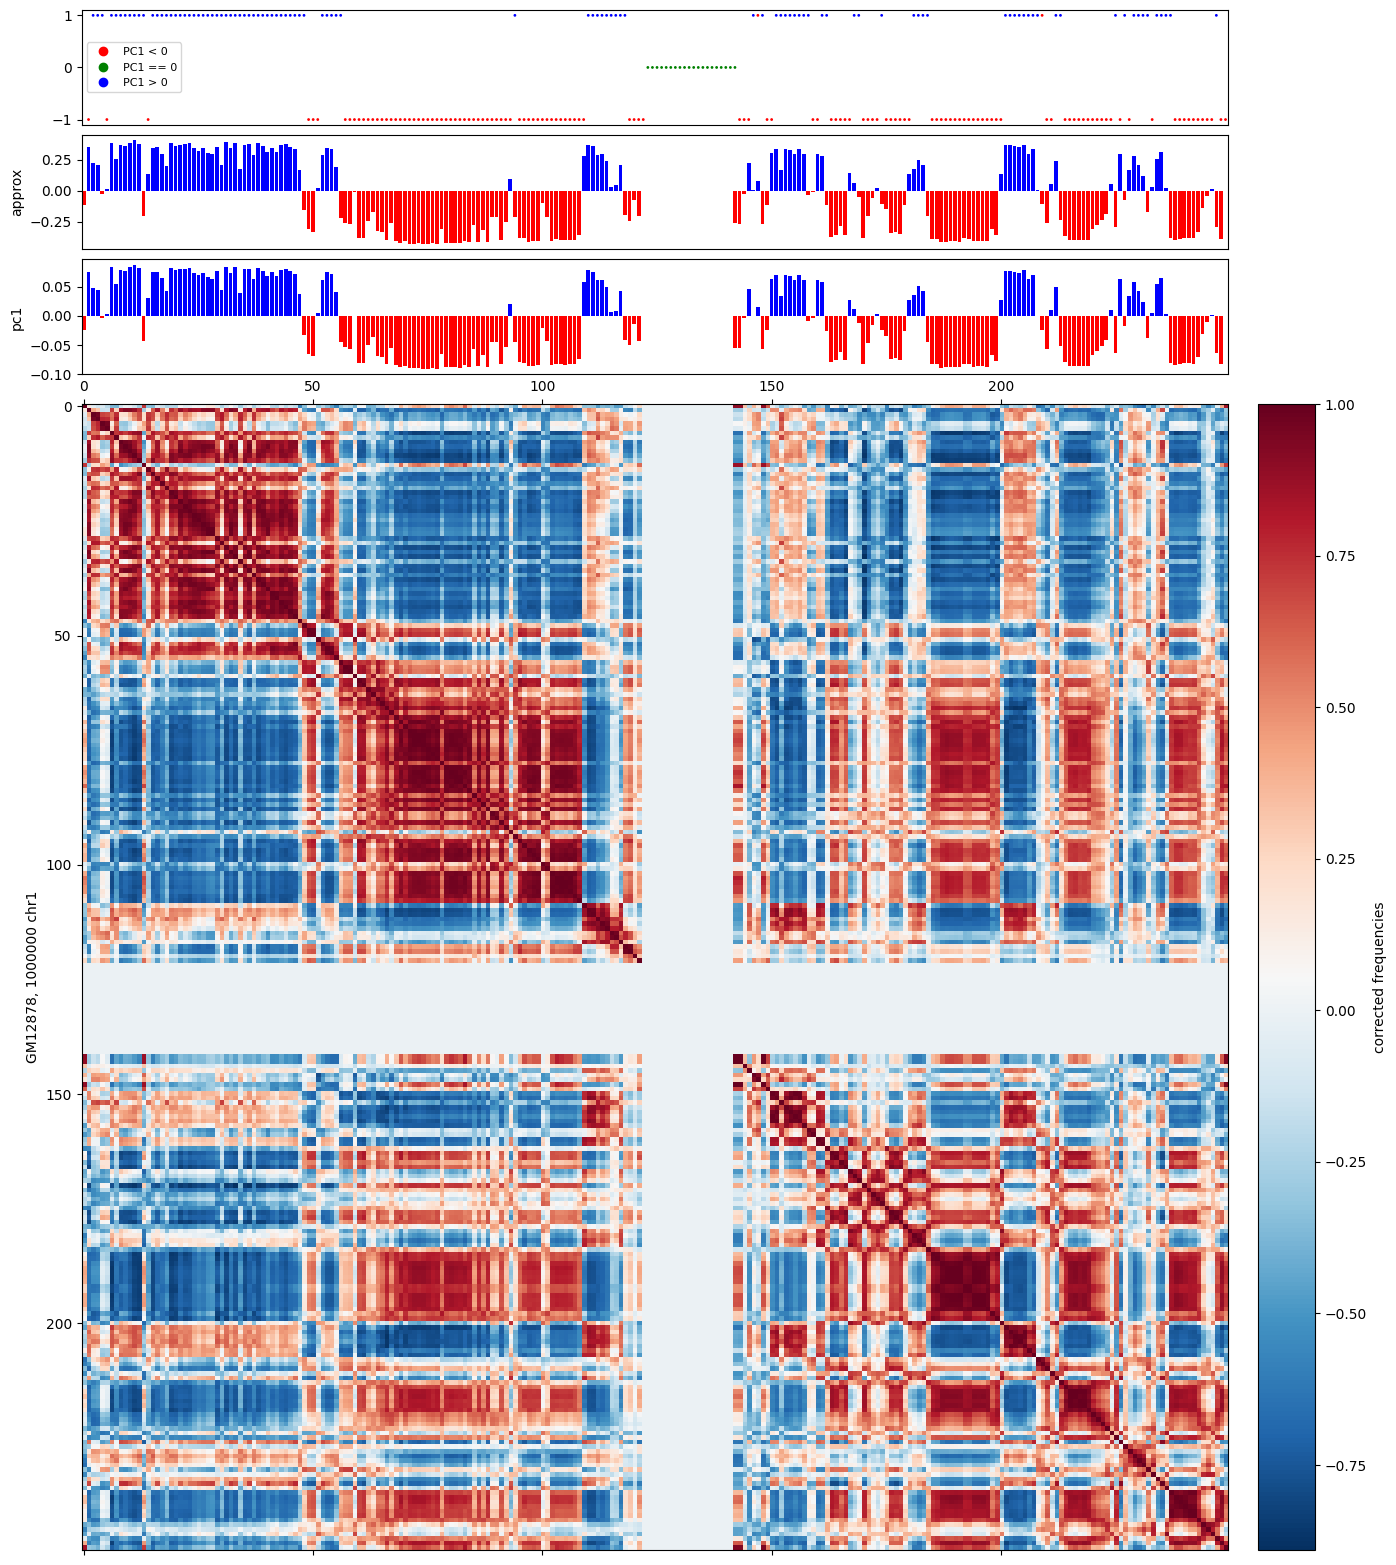

In [22]:
# Settings for pearson_np
f, ax = plt.subplots(
    figsize=(20, 20),
)
im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)
plt.colorbar(im, cax=cax, label='corrected frequencies')
ax.set_ylabel(f'{cell_line}, {resolution} chr{chrom}')

#### Settings for pc1_np
ax1 = divider.append_axes("top", size="10%", pad=0.3, sharex=ax)
pc1_x_axis = [i for i in range(0, len(pc1_np))]
pc1_bar_color = ['b' if i > 0 else 'r' for i in pc1_np]
ax1.bar(x=pc1_x_axis, height=pc1_np, color=pc1_bar_color)
ax1.set_ylabel('pc1')
ax1.xaxis.set_visible(False)

#### Settings for approx_np
ax2 = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
approx_x_axis = [i for i in range(0, len(approx_np))]
approx_bar_color = ['b' if i > 0 else 'r' for i in approx_np]
ax2.bar(x=approx_x_axis, height=approx_np, color=approx_bar_color)
ax2.set_ylabel('approx')
ax2.xaxis.set_visible(False)

#### Settings for pc1_np vs approx_np
similarity_info = paptools.calc_similarity(pc1_np, approx_np)
total_entry_num = similarity_info["total_entry_num"]
print(similarity_info)
plot_x_axis = [i + 1 for i in range(total_entry_num)]
approx_dots = [1 if i > 0 else -1 if i < 0 else 0 for i in approx_np]
pc1_colors_values = [2 if i > 0 else 0 if i < 0 else 1 for i in pc1_np]
pc1_colors = ListedColormap(['r', 'g', 'b'])
scatter_labels = ["PC1 < 0", "PC1 == 0", "PC1 > 0"]

ax3 = divider.append_axes("top", size="10%", pad=0.1, sharex=ax)
scatter_config = ax3.scatter(plot_x_axis, approx_dots, c=pc1_colors_values, cmap=pc1_colors, s=1)
ax3.legend(handles=scatter_config.legend_elements()[0], labels=scatter_labels, fontsize="8", loc="center left")
ax3.xaxis.set_visible(False)